In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F77BB660ED0>, 5)

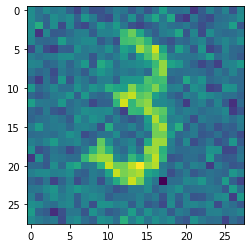

In [ ]:
import matplotlib.pyplot as plt
noized = dataset.data[1234].float() / 255 + torch.normal(
    torch.zeros_like(dataset.data[1234].float()), 
    0.2 * torch.ones_like(dataset.data[1234].float()))
plt.imshow(noized.detach().numpy())
plt.show()

In [ ]:
# hyperparams
in_chan = 1
hidden_ch = 100
out_ch = 1
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128


In [ ]:
class Encoder(nn.Module):
  #28x28 -> 14x14 -> 7x7 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do2 = nn.Dropout(0.1)
    self.conv_mu = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.conv_sigma = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.pool1(self.conv1(x))))
    x = self.do2(self.activ(self.pool2(self.conv2(x))))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.upsample1(self.conv1(x))))
    x = self.do2(self.activ(self.upsample2(self.conv2(x))))
    x = self.conv3(x)

    return x

def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma))
  return mu + sigma * norm

class ConvVarAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x, label):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden, label)

    return x_, mu, sigma


In [ ]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [ ]:
model_conv = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

epoch: 0, step: 0, loss: 0.022949762642383575
epoch: 0, step: 200, loss: 0.023819245398044586
epoch: 0, step: 400, loss: 0.022468512877821922


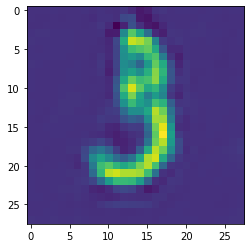

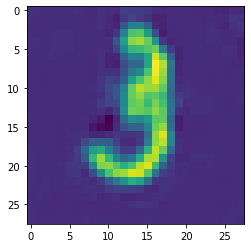

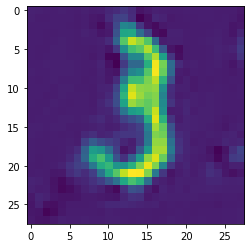

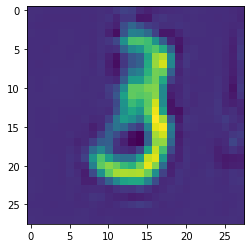

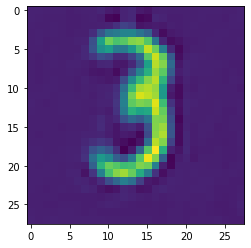

epoch: 1, step: 0, loss: 0.0231064110994339
epoch: 1, step: 200, loss: 0.022763624787330627
epoch: 1, step: 400, loss: 0.02318955957889557


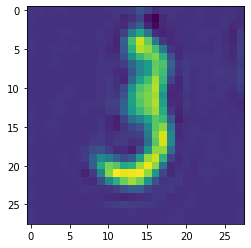

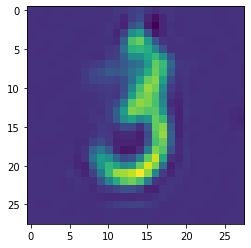

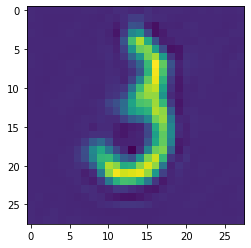

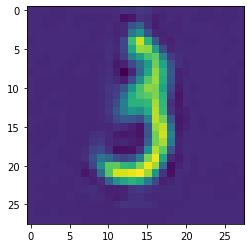

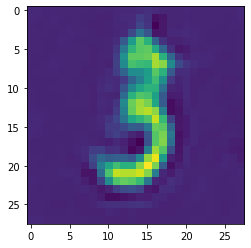

epoch: 2, step: 0, loss: 0.022569894790649414
epoch: 2, step: 200, loss: 0.02396557293832302
epoch: 2, step: 400, loss: 0.02338552474975586


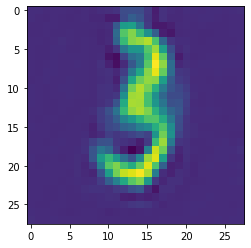

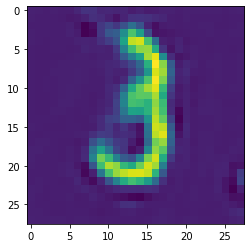

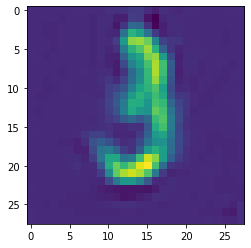

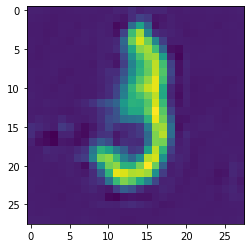

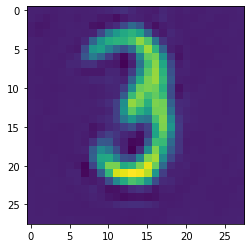

epoch: 3, step: 0, loss: 0.02327718585729599
epoch: 3, step: 200, loss: 0.02300868183374405
epoch: 3, step: 400, loss: 0.02326042577624321


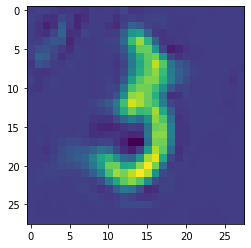

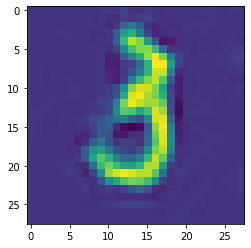

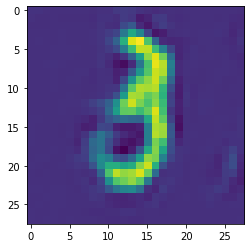

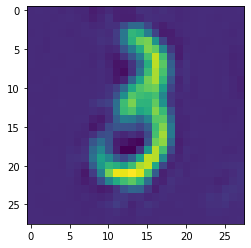

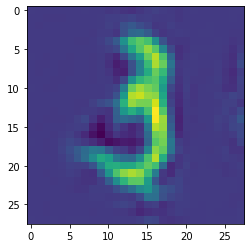

epoch: 4, step: 0, loss: 0.023013964295387268
epoch: 4, step: 200, loss: 0.022378461435437202
epoch: 4, step: 400, loss: 0.02258087694644928


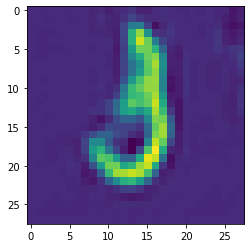

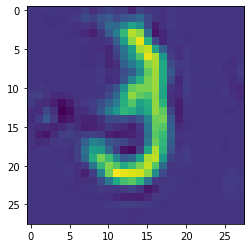

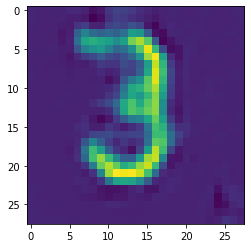

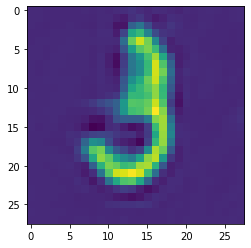

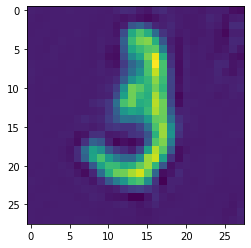

epoch: 5, step: 0, loss: 0.023022666573524475
epoch: 5, step: 200, loss: 0.023167168721556664
epoch: 5, step: 400, loss: 0.022666215896606445


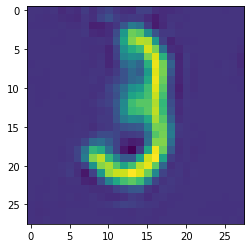

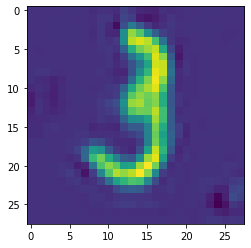

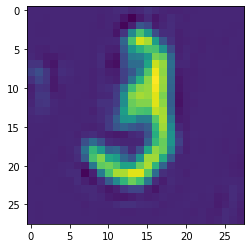

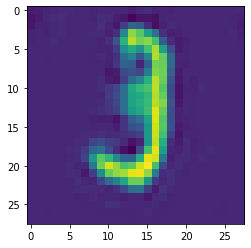

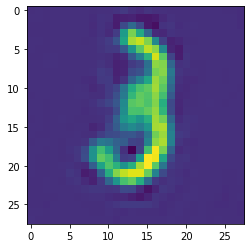

epoch: 6, step: 0, loss: 0.023119650781154633
epoch: 6, step: 200, loss: 0.022877424955368042
epoch: 6, step: 400, loss: 0.022420473396778107


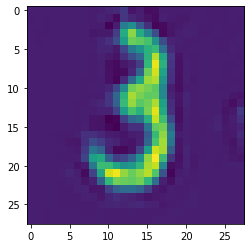

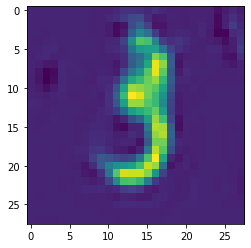

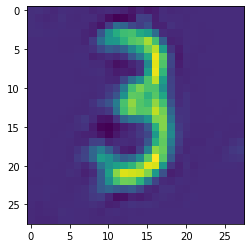

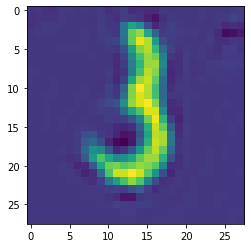

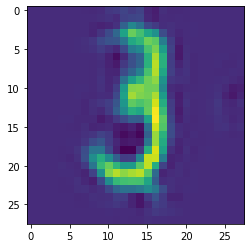

epoch: 7, step: 0, loss: 0.022647440433502197
epoch: 7, step: 200, loss: 0.022248921915888786
epoch: 7, step: 400, loss: 0.022257817909121513


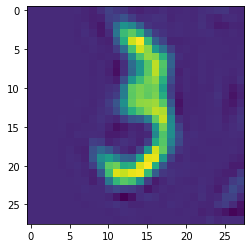

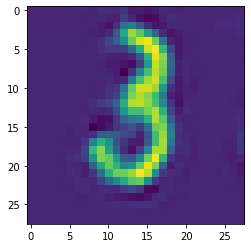

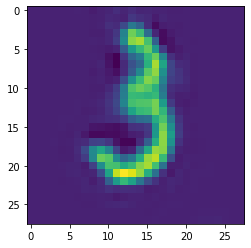

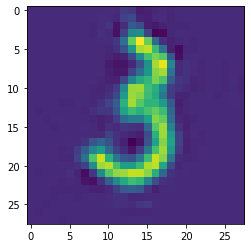

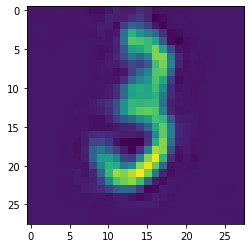

epoch: 8, step: 0, loss: 0.02173600159585476
epoch: 8, step: 200, loss: 0.022443199530243874
epoch: 8, step: 400, loss: 0.020919635891914368


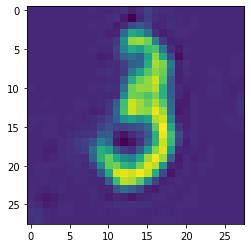

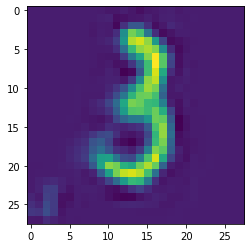

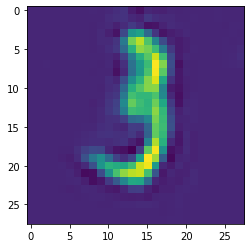

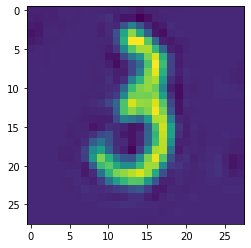

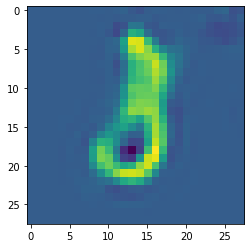

epoch: 9, step: 0, loss: 0.022488879039883614
epoch: 9, step: 200, loss: 0.022514626383781433
epoch: 9, step: 400, loss: 0.023171618580818176


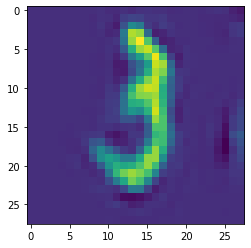

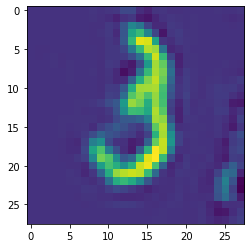

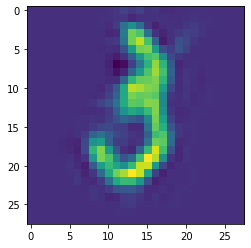

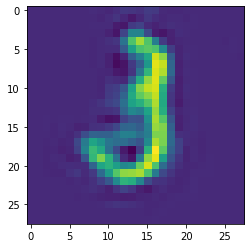

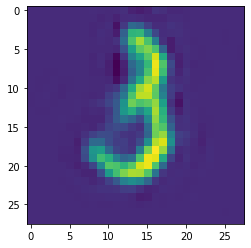

In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    # noized = torch.clamp(data + 
    #                      torch.normal(torch.zeros_like(data), 
    #                                   noise_factor * torch.ones_like(data)), 0., 1.)
    predict, mu, sigma = model_conv(data)
    loss = loss_func(predict, data) + 0.01 * kl_loss(mu, sigma)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  mu, sigma = model_conv.encoder(item.to(device))
  # item = torch.normal(torch.zeros((1,1,7,7)), 3 * torch.ones((1,1,7,7)))
  for i in range(5):
    plt.imshow(model_conv.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
    plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')